In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

### 神经网络
神经网络今天已经火的一塌糊涂了，因为深度学习的强大能力，机器学习成功地走出了数据科学领域，实现了图像识别、语音识别和NLP自然语言处理的各种重大突破。今天的CNN、RNN、AE、GAN甚至transformer，几乎都是基于最简单的神经网络NN前馈神经网络的。前馈神经网络使用感知机阵列搭建网络的层，把层与层级联起来，中间使用非线性的激活函数，就可以构造神经网络。神经网络有着非常好的数学优化性质，我们认为只要网络规模够大，神经网络可以拟合逼近任何函数。在此之上，如果我们使用一些其他的技巧，神经网络也能被当成一种概率模型，来逼近条件概率分布。
因为NN可以感知学习我们想要的任何信息，它可以在各种领域发光发热。以至于只要我们面临一个连续域的问题，都可以试一试用NN去逼近它。  
感知机的计算是x.w，向量与向量的乘积；对感知机阵列，将有多个x.w，对应多个输出，这个计算过程也可以写成**向量和矩阵的乘积**x.W。其梯度计算相对于感知机并没有什么大的改变，只不过是把向量的w提高到了矩阵的W，标量的y提高到了向量的y。但是X没有变化，矩阵求导的公式也不变。
$$ y=XW+b $$
$$ \frac{\partial L}{\partial W}=X^T\frac{\partial L}{\partial y}$$
$$ \frac{\partial L}{\partial b}=\frac{\partial L}{\partial y}$$
常用的非线性激活函数有tanh、sigmoid和relu等，tanh和sigmoid性质相近，因为tanh的数值更大，在很深层的网络里一般使用tanh。而relu一般用于图像识别的神经网络。
$$ f(v)=\frac {1} {1+e^{(-v)}}$$
$$ f^{'}(v)=f(v)(1-f(v)) $$
这里我们先按照上面说的，实现基础的线性层和激活函数层。但是在此之前，我们还要明确"反向传播"的概念。  
### 反向传播
back prop算法，用于计算神经网络中所有参数的梯度。实际上无非就是链式法则，看上面的W和b的梯度公式，我们计算参数关于loss的梯度时要先知道y关于loss的梯度，这个dL/dy要从后一层获得，因为这个y就是后一层的输入x，所以反向传播就是计算dL/dx。
$$
\frac{\partial L}{\partial X}=yW^T
$$
这样就能把误差传播到上一层，也就是反向传播这个名字的来源。如果是CNN、RNN等网络，还有更复杂的反向传播公式，但这里我们不讲。
### 神经网络的正则化
神经网络的拟合能力极为强大，但与此同时也很容易出现过拟合。前面讲过的正则化技巧也同样可以用在神经网络上。至于实现其实没什么好说的，和感知机一样做就好了。在计算梯度时，我们额外考虑一项L2惩罚
$$ \frac{\partial L}{\partial W} \leftarrow \lambda W+\frac{\partial L}{\partial W}$$
这就相当于我们为每个模型里的参数施加了一个平方惩罚，可以把无关参数压到接近于0，能有效控制过拟合。  
### MSGD
带动量的梯度下降，每次参数更新不是完全用当前的梯度，而是基于原本的下降方向作出调整。这样可以确定一个比较稳定的下降方向，本质上是共轭梯度法的简化版本。共轭梯度法希望通过方向修正，让所有的下降方向尽可能正交。而如果我们把修正系数设为常数，就是MSGD算法。
$$ d \leftarrow \beta d+(1-\beta)\alpha\frac{\partial L}{\partial W}$$

In [2]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = 1/(1+np.exp(-x))
        return self.out
    
    def backward(self, dz):
        return dz*self.out*(1-self.out)
    

class Linear:
    def __init__(self,input_sz,output_sz, LEARNING_RATE=0.01,
                 LAMBDA = 0, momentum = 0.9):
        self.W = np.random.randn(input_sz,output_sz)*0.02
        self.b  = np.random.randn(output_sz)*0.01
        
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
        self.lr = LEARNING_RATE
        self.lamda = LAMBDA
        self.momentum = momentum
        
        self.X = None
        
    def forward(self,X):
        self.X = X
        out =  np.dot(self.X,self.W)+self.b
        return out
    
    def backward(self,dz):
        """
        dz-- 前面的导数
        基于反向传播的dz和动量、学习率，更新W和b
        """
        n,m = self.X.shape
        
        self.dW, self.db = self.dW*self.momentum, self.db*self.momentum
        dw = np.dot(self.X.T,dz)/n
        dw += self.lamda*self.W
        self.dW += self.lr*dw*(1-self.momentum)
        
        db = np.mean(dz, axis = 0)
        self.db += self.lr*db*(1-self.momentum)
        dx = np.dot(dz,self.W.T)
        
        return dx
    
    def update(self):
        #更新W和b
        self.W = self.W-self.dW
        self.b = self.b-self.db
        return

In [3]:
def sequential_forward(layers, x):
    for layer in layers:
        x = layer.forward(x)
    return x

def sequential_backward(layers, dz):
    for layer in layers[::-1]:
        dz = layer.backward(dz)
    return dz

我们来搭建一个神经网络，拟合之前用多项式和线性回归做过的波士顿房价预测问题

In [4]:
class NN:    
    def __init__(self, LEARNING_RATE=0.01,LAMBDA = 0, MOMENTUM = 0.9):
        lr = LEARNING_RATE
        lmd = LAMBDA
        mom = MOMENTUM
        # 输入:13维特征
        self.layers = [
            Linear(13,20,lr,lmd,mom),
            Sigmoid(),
            Linear(20,20,lr,lmd,mom),
            Sigmoid(),
            Linear(20,1,lr,lmd,mom)
        ]
        # 输出:1维标量

    def forward(self, X):
        X = sequential_forward(self.layers, X)
        self.out = X
        return X

    def backward(self,y):
        # 使用均方误差
        dz = self.out-y
        self.loss = np.mean((dz)**2)
        dz = sequential_backward(self.layers, dz)
        return dz

    def update(self):
        for layer in self.layers:
            if type(layer)==Linear:
                layer.update()
                
    def fit(self, X, y, epochs, batch_sz):
        n,m = X.shape
        for epoch in range(epochs):
            for i in range(0,n,batch_sz):
                inputs = X_train[i:i+batch_sz]
                labels = y_train[i:i+batch_sz]
                model.forward(inputs)
                model.backward(labels)
                model.update()
        return

In [5]:
X,y = datasets.load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#数据标准化处理
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [6]:
model = NN()
model.fit(X_train,y_train,500,32)

In [7]:
# 计算训练集和测试集的L1 loss
loss = np.mean(np.abs((model.forward(X_train)-y_train)))
print("L1 loss on training set: %.2f"%loss)
loss = np.mean(np.abs((model.forward(X_test)-y_test)))
print("L1 loss on testing set: %.2f"%loss)

L1 loss on training set: 1.53
L1 loss on testing set: 2.83


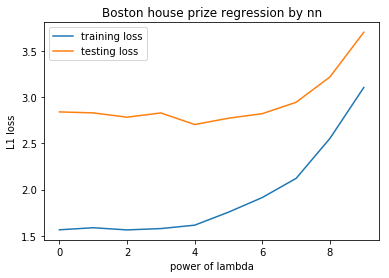

In [9]:
# 我们也可以尝试不同的lambda进行正则化，防止网络过拟合
train_loss = []
test_loss = []
lamda_list = [0.0005*2**i for i in range(10)]

for lamda in lamda_list:
    model = NN(LAMBDA = lamda)
    model.fit(X_train,y_train,500,32)
    
    #计算训练集和测试集上的L1误差
    loss = np.mean(np.abs((model.forward(X_train)-y_train)))
    train_loss.append(loss)
    loss = np.mean(np.abs((model.forward(X_test)-y_test)))
    test_loss.append(loss)

plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='testing loss')
plt.title('Boston house prize regression by nn')
plt.ylabel('L1 loss')
plt.xlabel('power of lambda')
plt.legend()

### 神经网络的分类问题
之前我们学习线性模型时，一般会构造多个判别器来实现多分类，但是神经网络有着更好的做法。我们知道神经网络允许多输出，那么能不能让神经网络直接输出每个类别的概率呢？答案是可以，为此我们要引入一个特殊的软化概率函数，以及BCEloss的原型，Cross Entropy Loss。  
softmax是有限项离散概率分布的梯度对数归一化，也被称为归一化指数函数。softmax的计算如下$$ \sigma(z)_j = \frac{e^{z_j}}{\sum_{i=1}^N e^{z_i}} $$
函数的输入是从K个不同的线性函数得到的结果，而样本向量 x 属于第 j 个分类的概率为softmax的输出。它相当于让神经网络输出了一个离散条件概率分布
$$ p(z\quad|X,W) $$
即给定输入X和模型参数W下分类为z的概率，而我们在分类问题中希望优化的目标是:让训练集的真实条件概率分布和模型输出的概率分布尽可能相同。我们知道评估概率分布差异的方法是KL散度，而最优化KL散度的过程又可以简化为优化Cross Entropy的过程。离散概率分布的交叉熵写做
$$  L(W) = -\frac{1}{N}\sum_{i=1}^{N}log(p(z_i)) $$
它是模型接收第i个训练集后，我们预期的正确分类的概率的负对数的加和。我们假设训练集是从p(x)的真实采样，则此方法获得的是真实交叉熵的蒙特卡洛估计。把softmax的输出代入，可以计算单个样本输入时，L(W)的导数。
$$  L(W) = -log(\frac{e^{z_j}}{\sum_{i=1}^N e^{z_i}}) $$
计算Loss关于各z_i输入的偏导数，要分为i=j和i!=j讨论
$$ \frac{\partial{L}}{\partial{z_i}} = \frac{e^{z_i}}{\sum_{k=1}^N e^{z_k}} \quad \quad (i\neq j) $$
$$ \frac{\partial{L}}{\partial{z_i}} = \frac{e^{z_i}-\sum_{k=1}^N e^{z_k}}{\sum_{k=1}^N e^{z_k}}=\frac{e^{z_i}}{\sum_{k=1}^N e^{z_k}}-1 \quad \quad (i = j) $$
如果把标签写成one hot的向量，即正确标签为1，错误标签为0，就能给出非常简单的向量梯度形式
$$ \frac{\partial{L}}{\partial{z}} = z-labels $$
我们实现一个softmax层，然后就可以搭建能完成多分类任务的神经网络了。

In [10]:
def cross_entropy_error(labels,logits):
    return np.mean(-np.sum(labels*np.log(logits),axis=1))

def softmax(input_X):
    n,m = input_X.shape
    exp_a = np.exp(input_X)
    sum_exp_a = np.sum(exp_a,axis=1)
    sum_exp_a = np.tile(sum_exp_a,(m,1))
    sum_exp_a = sum_exp_a.T
    ret = exp_a/sum_exp_a
    return ret

class SoftMax:
    '''
    softmax，归一化层，把输出转概率
    该层的输出代表每一分类的概率
    '''
    def __init__ (self):
        self.y_hat = None
        
    def forward(self,X):
        self.X = X
        self.y_hat = softmax(X)
        return self.y_hat
    
    def backward(self,labels):
        # 使用cross entropy
        dx = (self.y_hat-labels)
        return dx

我们搭建一个神经网络来分类sklearn提供的手写数字数据集，不用MNIST是因为MNSIT跑起来太慢了。

In [11]:
class NN:    
    def __init__(self, LEARNING_RATE=0.01,LAMBDA = 0, MOMENTUM = 0.9):
        lr = LEARNING_RATE
        lmd = LAMBDA
        mom = MOMENTUM
        # 输入:8x8 = 64维特征
        self.layers = [
            Linear(64,128,lr,lmd,mom),
            Sigmoid(),
            Linear(128,64,lr,lmd,mom),
            Sigmoid(),
            Linear(64,32,lr,lmd,mom),
            Sigmoid(),
            Linear(32,10,lr,lmd,mom),
            SoftMax()
        ]
        # 输出:10维分类

    def forward(self, X):
        X = sequential_forward(self.layers, X)
        self.out = X
        return X

    def backward(self,y):
        # 使用softmax和交叉熵
        self.loss = cross_entropy_error(y,self.out)
        dz = y
        dz = sequential_backward(self.layers, dz)
        return dz

    def update(self):
        for layer in self.layers:
            if type(layer)==Linear:
                layer.update()
                
    def fit(self, X, y, epochs, batch_sz):
        n,m = X.shape
        for epoch in range(epochs):
            for i in range(0,n,batch_sz):
                inputs = X_train[i:i+batch_sz]
                labels = y_train[i:i+batch_sz]
                model.forward(inputs)
                model.backward(labels)
                model.update()
        return

In [12]:
def one_hot_encode(labels):
    '''
    labels:一维数组，返回独热编码后的二维数组
    '''
    labels = labels.astype(np.int)
    n = len(labels)
    m = labels.max()+1
    ret = np.zeros((n,m))
    rows = np.linspace(0,n-1,n).astype(np.int)
    ret[rows,labels] = 1
    return ret

In [13]:
X,y = datasets.load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

y_train = one_hot_encode(y_train)

#处理图片的一般预处理方法是归一化到0-1区间
sc_MM = MinMaxScaler()
X_train = sc_MM.fit_transform(X_train)
X_test = sc_MM.transform(X_test)

Text(0.5,0,'epoch(25)')

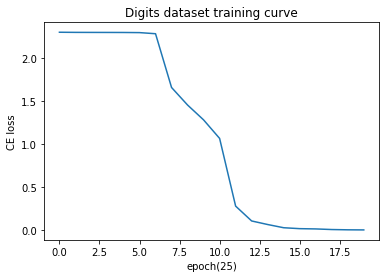

In [15]:
model = NN(LEARNING_RATE=0.5)
losses = []
for step in range(20):
    model.fit(X_train,y_train,25,50)
    losses.append(model.loss)
plt.plot(losses)
plt.title('Digits dataset training curve')
plt.ylabel('CE loss')
plt.xlabel('epoch(25)')

In [16]:
def one_hot_decode(prob):
    '''
    prob:二维数组，返回标签一维数组
    '''
    return np.argmax(prob,axis = 1)

In [17]:
y_test_pred = one_hot_decode(model.forward(X_test))
accuracy_score(y_test_pred,y_test)

0.9611111111111111

### 过拟合
神经网络有着非常惊艳的拟合能力，上面我们已经看到了神经网络可以逼近函数和概率分布，实现多种有趣的任务。但是和上面的玩具数据集做出来的结果不同，神经网络在实际问题里非常有可能出现更为严重的过拟合。而除了上面的正则化方法以外，我们还有其他方法控制过拟合。  
**Eealy Stop**  
一种相当直觉的方法，但是经常能够凑效。我们在训练时用一个验证集辅助训练，一旦训练出现了让测试集loss下降的趋势就立刻停止训练。  
**DropOut**  
从模型融合中得到启发，做过Kaggle的人应该有经验，在模型和算法已经完善的末期，我们进一步提升正确率的方法就是在模型中引入随机因素，制造很多的模型形成委员会，用这个混合的模型进行任务决策。而神经网络自己本就是一个混合模型，如果我们使用dropout的技巧，即每次训练时，随机临时删除一些 神经元，它们将不在这次运算中发挥作用，同样也不会被更新。这样，一个神经网络就相当于多个小型神经网络的混合模型，这个方法在大型任务重常常很实用。  
**更好的数据集**  
更多更好的数据是防止过拟合的最好方法，即使没有更多的数据，我们也可以用一些技巧创造数据。这个做法在图像和语音领域尤其适用，我们可以随机对图片进行旋转，平移，加噪声，来获得更多更稳定的数据集。  
**reinforcement**
强化学习是一种特殊的方法，它基于模型的对抗进行。在对弈和决策问题里，我们可以通过模型对抗的方式让模型自行学习，从而获得超越数据集的成效。最好的例子就是击败人类的alphago。

In [18]:
class Dropout:
    '''
    随机把一些神经元的输出变为0
    从而前向和反向传播中，这个神经元将不再发挥作用
    '''
    def __init__ (self, prob, train = True):
        self.p = prob # dropout 的概率
        self.train = train # 训练模式，dropout层启用
        
    def forward(self,X):
        if not self.train: return X
        self.mask = np.random.rand(len(X))>self.p
        X[self.mask] = 0
        return X
    
    def backward(self,dz):
        if not self.train: return dz
        dz[self.mask] = 0
        return dz

In [19]:
class NN:    
    def __init__(self, LEARNING_RATE=0.01,LAMBDA = 0,
                 MOMENTUM = 0.9, DropOut_rate = 0.5):
        lr = LEARNING_RATE
        lmd = LAMBDA
        mom = MOMENTUM
        rate = DropOut_rate
        # 输入:13维特征
        self.layers = [
            Linear(13,50,lr,lmd,mom),
            Sigmoid(),
            Dropout(rate),
            Linear(50,50,lr,lmd,mom),
            Sigmoid(),
            Linear(50,10,lr,lmd,mom),
            Sigmoid(),
            Linear(10,3,lr,lmd,mom),
            SoftMax()
        ]
        # 输出:10维分类

        
    def eval(self):
        # 计算模式，关闭所有dropout
        for layer in self.layers:
            if type(layer)==Dropout:
                layer.train = False
                
                
    def train(self):
        # 训练模式，开启所有dropout
        for layer in self.layers:
            if type(layer)==Dropout:
                layer.train = True
        
    def forward(self, X):
        X = sequential_forward(self.layers, X)
        self.out = X
        return X

    def backward(self,y):
        # 使用softmax和交叉熵
        self.loss = cross_entropy_error(y,self.out)
        dz = y
        dz = sequential_backward(self.layers, dz)
        return dz

    def update(self):
        for layer in self.layers:
            if type(layer)==Linear:
                layer.update()
                
    def fit(self, X, y, epochs, batch_sz):
        n,m = X.shape
        for epoch in range(epochs):
            for i in range(0,n,batch_sz):
                inputs = X_train[i:i+batch_sz]
                labels = y_train[i:i+batch_sz]
                model.forward(inputs)
                model.backward(labels)
                model.update()
        return

In [20]:
X,y = datasets.load_wine(return_X_y=True)

# 我们设置较高的test_size来观察过拟合的发生
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.4, random_state = 0)

y_train = one_hot_encode(y_train)

#数据标准化处理
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [21]:
model = NN(LEARNING_RATE=0.5,DropOut_rate=0.5)
model.train()
model.fit(X_train,y_train,1000,20)

In [22]:
model.eval()
y_test_pred = one_hot_decode(model.forward(X_test))
accuracy_score(y_test_pred,y_test)

0.9583333333333334

### 神经网络优化遇到的问题
**局部最优**  
我们一直避而不谈的一个问题是，为什么神经网络能用SGD train到全局最优？前面学习逻辑回归时，梯度下降能把loss优化到最优，是因为不论是MSE误差，还是BCE误差，它们在逻辑回归的模型上都是凸优化，所以我们必然能用梯度下降找到最优解。但神经网络不同，我们并不知道它是不是凸优化啊？  
事实上也和我们的直觉相同，神经网络不是凸优化，而且我们也很难去找到一个全局最优。一个相当反直觉的现实是，我们连局部最优都很难找到。优化理论告诉我们，一个函数上的某点如果是局部最优，那么它的Hessian矩阵是正定的。正定的矩阵要求所有矩阵特征值都是正的，而在一个大型网络里，对成千上万的参数所在的高维空间，计算出的H矩阵将会非常巨大，特征值也非常多。而想找到一个点让所有特征值都是正的极为困难，也就是，在参数空间内，我们几乎不可能触摸到局部最优，这也就让所谓被"局部最优"卡住，找不到全局最优的事情几乎不可能发生。  
**鞍点**   
换句话来说，我们训练神经网络时面对的问题并不是被局部最优限制，而是被一般的0梯度点，即鞍点限制。而幸运的是，鞍点并不具备局部最小点的那种强大的吸引力，在随机梯度下降和随机初始化下生成的网络，虽然会经过鞍点，但在连续的梯度下降优化下，都会跳出鞍点。而牛顿法之所以无法在神经网络优化中取得比较好的效果，就是因为它会落入鞍点。  
**高原**  
还有一些在使用sigmoid和tanh时我们不会遇到的问题，如果我们使用relu作为激活函数，则loss的空间很有可能出现大片的，平坦的区域。在这些区域上梯度完全为0，优化无法继续进行。一种解决方案是使用leaky relu，使用更好的参数初始化策略，和更好的梯度学习算法。  
**梯度爆炸与消失**  
在深层的计算图中，梯度很可能随着反向传播衰减，以至于梯度很快为接近于0.这一点在深度的卷积网络和RNN中经常出现，CNN解决这个问题的方法是把上层的神经元直接和几层后的神经元连接，允许梯度跨层传播，抑制梯度的消失。RNN中因为计算图要随着序列长度变化，梯度还很容易变得陡峭，RNN解决这个问题的方法是使用更柔和的LSTM。  
**我们想要的**  
回顾一下我们上面做的事情，我们想要的不是神经网络能完美拟合训练集，而是具有最好的泛化能力。所以我们才用了那么多的方法防止过拟合，这也说明了，找不到一个全局最优其实一点都不重要，全局最优一般对应着较差的泛化能力，我们真正的训练，很多时候都是"什么都没有做到"就停止训练了，但这并不重要。